## 使用ライブラリの読み込み

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## データをimportする

In [42]:
data = pd.read_csv("retail_sample_data.csv")

In [43]:
data.head()

,inventory_qty,Color,Size,Price,Brand,P/L
0,15,blue,S,41.0,Adidas,P
1,13,red,S,74.0,Puma,P
2,12,grey,S,896.0,Puma,P
3,14,red,M,556.0,Puma,L
4,14,grey,M,755.0,Puma,P


### 欠損値の確認

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 6 columns):
inventory_qty    38 non-null int64
Color            38 non-null object
Size             38 non-null object
Price            32 non-null float64
Brand            38 non-null object
P/L              38 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 1.9+ KB


ここで、`Price`に欠損値が含まれているのがわかる。

## Step1. 各変数ごとの分析

### 1. inventory_qty

在庫数を表すので、離散的数値と見なす以外はあまり考えられない。

#### 外れ値の検出

seabornというデータ可視化に特化したライブラリを使用し、外れ値を視覚的に検知する。<br>
ここでは箱ひげ図（Box Plot）と正規図（Distribution Plot）を描写し、外れ値を見つける。

[Text(0.5, 0, '')]

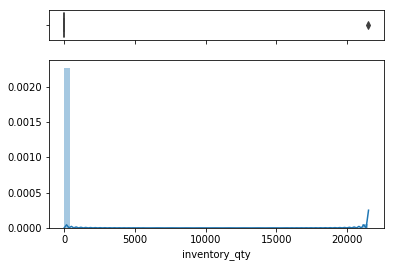

In [45]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(data["inventory_qty"], ax=ax_box)
sns.distplot(data["inventory_qty"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

図で明らかなように、一つだけ数値が突出しているデータがある。以下では、このデータ（外れ値）を取り除き、再度プロットしてみる。

In [46]:
data = data[data["inventory_qty"] <= 1500]

[Text(0.5, 0, '')]

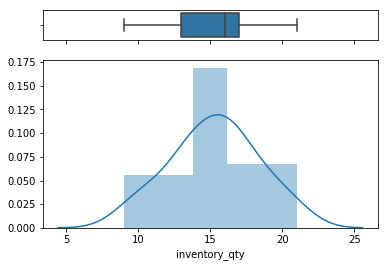

In [47]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(data["inventory_qty"], ax=ax_box)
sns.distplot(data["inventory_qty"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

外れ値のあるデータを取り除くことができたのがわかる。

### 2. Color

色は文字列であり、色による優位性は※今回ないため、明らかにカテゴリカルデータである。<br>
※色の明るさによって目的変数が変わりそうであれば、これを数値に変換することも可能である。

文字列データは分析がしづらいため、数値に加工する必要がある。<br>
blue = 0, red = 1, grey = 2のように番号を採番しても良いが、これをbooleanの変数の集合体であると見なす方がいい。<br>
というのも、この数値に意味がないからだ。<br>
つまり、この`Color`という一つのカラムから、blueか否か、redか否か、greyか否かというようなbooleanな複数カラムに加工するということ。<br>
これを<b>ダミー変数変換</b>という。

In [48]:
data_color = pd.get_dummies(data['Color'])

In [49]:
data = pd.concat([data, data_color], axis=1)

In [50]:
data.head()

,inventory_qty,Color,Size,Price,Brand,P/L,blue,grey,red,yellow
0,15,blue,S,41.0,Adidas,P,1,0,0,0
1,13,red,S,74.0,Puma,P,0,0,1,0
2,12,grey,S,896.0,Puma,P,0,1,0,0
3,14,red,M,556.0,Puma,L,0,0,1,0
4,14,grey,M,755.0,Puma,P,0,1,0,0


カテゴリカルデータであった`Color`という一カラムを、離散的数値の複数カラムに変換した。<br>
ちなみに、元のカラムは機械学習の直前まで使用するかもしれないので、残しておく。

### 3. Size 

サイズはS,M,L,XLのような文字列で表される。大きさを示しているので、数値に変換し、離散的数値として扱う場合が多い。<br>
見方によってはこれを大きさではなく、あくまでカテゴリとして扱うこともできる。<br>
その場合、`Color`のようにbooleanの変数の集合体でもいいと思う。<br>
今回は、離散的数値として扱うために数値変換を行う。

In [51]:
data_size = data['Size'].drop_duplicates().reset_index()
data_size['size_num'] = [1,2,3,4]

In [52]:
#Left Joinする
data = pd.merge(left=data,right=data_size, how='left', left_on='Size', right_on='Size')
data = data.drop(columns=['index'])
data.head()

,inventory_qty,Color,Size,Price,Brand,P/L,blue,grey,red,yellow,size_num
0,15,blue,S,41.0,Adidas,P,1,0,0,0,1
1,13,red,S,74.0,Puma,P,0,0,1,0,1
2,12,grey,S,896.0,Puma,P,0,1,0,0,1
3,14,red,M,556.0,Puma,L,0,0,1,0,2
4,14,grey,M,755.0,Puma,P,0,1,0,0,2


### 4. Price

Priceは離散的数値の場合もあるし連続的数値にも取れる。<br>
というのも店によっては小数点単位で値段設定しているので。<br>
既に欠損値があることがわかっているので、まずは欠損値を処理する。<br>
※欠損値を処理しないと、plotを作成する際にエラーになることがあるので、優先すること。

#### 欠損値処理

特徴量エンジニアリング（Feature engineering）を学習すると、欠損値処理の作法を学べる。<br>
今は、あまり深入りするとややこしいので簡単な欠損値処理を紹介する。<br>
と言ってもとてもシンプルで、平均値を欠損箇所に埋めるだけ。<br>

平均値は、`median`、`mode`, `mean`のどれかだが、今回は独断で`median`を使用する。

In [53]:
median_price = np.median(data['Price'].dropna())
median_price

420.0

In [54]:
data['price_adj'] = data['Price'].fillna(median_price)
data.head()

,inventory_qty,Color,Size,Price,Brand,P/L,blue,grey,red,yellow,size_num,price_adj
0,15,blue,S,41.0,Adidas,P,1,0,0,0,1,41.0
1,13,red,S,74.0,Puma,P,0,0,1,0,1,74.0
2,12,grey,S,896.0,Puma,P,0,1,0,0,1,896.0
3,14,red,M,556.0,Puma,L,0,0,1,0,2,556.0
4,14,grey,M,755.0,Puma,P,0,1,0,0,2,755.0


箱ひげ図（Box Plot）と正規図（Distribution Plot）を描写し、外れ値がないか確認する。

[Text(0.5, 0, '')]

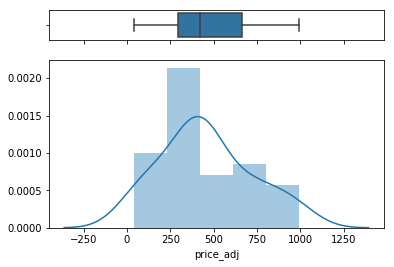

In [55]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(data["price_adj"], ax=ax_box)
sns.distplot(data["price_adj"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

外れ値がないことがわかる。

### 5. Brand

カテゴリカルデータと見なす（それ以外は考えづらい）ので、Colorと同じく、ダミー変数変換を行う。

In [56]:
data_brand = pd.get_dummies(data['Brand'])
data = pd.concat([data, data_brand], axis=1)
data.head()

,inventory_qty,Color,Size,Price,Brand,P/L,blue,grey,red,yellow,size_num,price_adj,Adidas,Champion,Puma
0,15,blue,S,41.0,Adidas,P,1,0,0,0,1,41.0,1,0,0
1,13,red,S,74.0,Puma,P,0,0,1,0,1,74.0,0,0,1
2,12,grey,S,896.0,Puma,P,0,1,0,0,1,896.0,0,0,1
3,14,red,M,556.0,Puma,L,0,0,1,0,2,556.0,0,0,1
4,14,grey,M,755.0,Puma,P,0,1,0,0,2,755.0,0,0,1


### 6. P/L

最後に、目的変数である`P/L`を0,1に変換する。

In [57]:
data['P/L'] = data['P/L'].replace('L', 0)
data['P/L'] = data['P/L'].replace('P', 1)
data.head()

,inventory_qty,Color,Size,Price,Brand,P/L,blue,grey,red,yellow,size_num,price_adj,Adidas,Champion,Puma
0,15,blue,S,41.0,Adidas,1,1,0,0,0,1,41.0,1,0,0
1,13,red,S,74.0,Puma,1,0,0,1,0,1,74.0,0,0,1
2,12,grey,S,896.0,Puma,1,0,1,0,0,1,896.0,0,0,1
3,14,red,M,556.0,Puma,0,0,0,1,0,2,556.0,0,0,1
4,14,grey,M,755.0,Puma,1,0,1,0,0,2,755.0,0,0,1


## Step2. データを包括的に見る

Step1でデータがある程度綺麗になった、つまり、見やすくもなった。<br>
なので、今度はデータにどんな傾向があるのかを見る。<br>
もっとも代表的なものとして、
1. pandas.dataframeの<b>describe()</b><br>
2. seabornが提供する<b>heatmap</b>

などが挙げられる。<br>
実際に以下で使用する。<br>

In [58]:
data.describe()

,inventory_qty,Price,P/L,blue,grey,red,yellow,size_num,price_adj,Adidas,Champion,Puma
count,37.000000,31.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,15.270270,463.903226,0.729730,0.216216,0.243243,0.459459,0.081081,2.594595,456.783784,0.324324,0.270270,0.405405
std,3.033596,285.494350,0.450225,0.417342,0.434959,0.505228,0.276725,1.039750,261.135356,0.474579,0.450225,0.497743
min,9.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,41.000000,0.000000,0.000000,0.000000
25%,13.000000,270.500000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,292.000000,0.000000,0.000000,0.000000
50%,16.000000,420.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,420.000000,0.000000,0.000000,0.000000
75%,17.000000,670.000000,1.000000,0.000000,0.000000,1.000000,0.000000,3.000000,665.000000,1.000000,1.000000,1.000000
max,21.000000,990.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,990.000000,1.000000,1.000000,1.000000


これでなんとなく、ばらつきがあるか(std)、平均がどのくらいかがわかる。

次にseabornが提供するheatmapを見てみる。欠損値や数値でないカラムがあるとエラーになるので、実行時には除いておく。

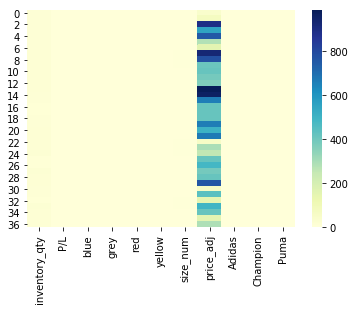

In [59]:
data_heatmap = data.drop(columns=['Color','Size','Brand','Price'])
sns.heatmap(data_heatmap,cmap="YlGnBu")

うん。見辛い。忘れたけど、数値を標準化しないと、顕著な数字が目立ってしまう。<br>
今回は広く浅くなので、標準化はせず、顕著な`price_adj`を除く。

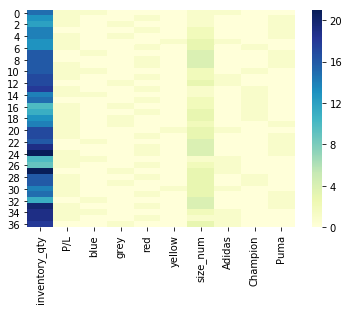

In [60]:
data_heatmap = data.drop(columns=['Color','Size','Brand','Price','price_adj'])
sns.heatmap(data_heatmap, cmap="YlGnBu")

目的変数でソートする。

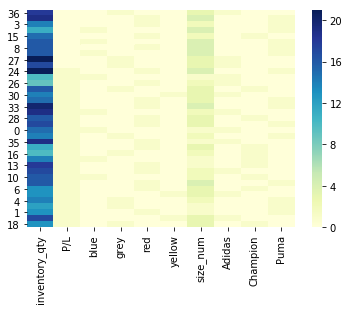

In [61]:
data_heatmap = data_heatmap.sort_values(by=['P/L'])
sns.heatmap(data_heatmap, cmap="YlGnBu")

特に、顕著な特徴は見受けられなかった。<br>
強いて言うなら、黄色の商品は必ず`Profit`なので、今後の分析で大きなFactorになりうる。

## Step3. 変数間の関係を見る

#### ペアプロット図

多くの変数があるときに変数ペア間の関係を調べたい場合はペアプロット図（プロット行列）を描くのが有効である。<br>
以下では、seabornの`pairplot`を使い、数値変数のペアプロット図を描く。
seabornの`pairplot`では、ペアプロット図の他に、対角線上にヒストグラムを描くことができる（正確にはカーネル密度推定グラフ）。
また、`pairplot`の`hue`パラメーターにカラムを指定すると、そのカラムの値別にデータを分類してくれる。
つまり、`hue`に目的変数である`P/L`を指定すると、P、Lごとにデータを分類してグラフ化してくれる。

以下、実際にグラフを描写する。

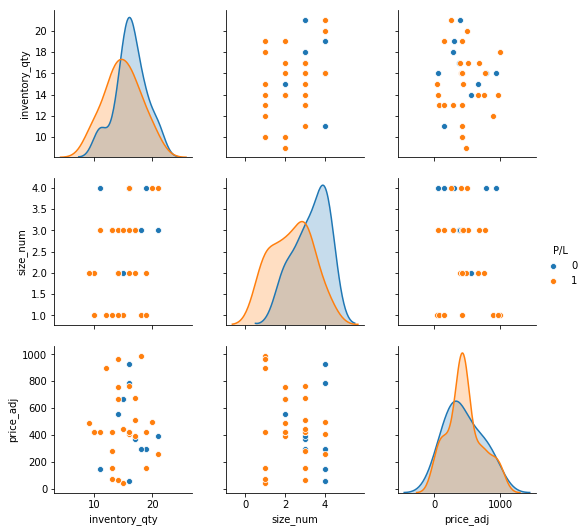

In [62]:
sns.pairplot(data, hue="P/L", vars=['inventory_qty','size_num','price_adj'])

見てわかるように、`size_num`の場合、データがうまく分散されず見辛い。<br>
これが離散的数値を可視化するときのデメリットである。できるなら、プロット図は連続的数値のみに限定する方がいいだろう。<br>
とはいえ、図を見ると`size_num`が大きいとL、つまり損失しやすいことに気づくことができる。

#### カテゴリカルデータのカテゴリ別特徴の可視化

カテゴリカルデータの値ごとにデータを分けると、データの特徴に気づくことがある。<br>
例えば、ブランド別に値を分けたときに、高級ブランドの商品の値段の平均値が顕著に高いかもしれない。<br>
今回、カテゴリ別平均値を示す。

In [63]:
#Priceは欠損値があるので除く
data = data.drop(columns=['Price'])
data.groupby('Color').mean()

,inventory_qty,P/L,blue,grey,red,yellow,size_num,price_adj,Adidas,Champion,Puma
Color,,,,,,,,,,,
blue,14.625000,0.625000,1.0,0.0,0.0,0.0,2.375000,425.375000,0.375000,0.250000,0.375000
grey,15.000000,0.666667,0.0,1.0,0.0,0.0,2.444444,552.444444,0.333333,0.333333,0.333333
red,15.823529,0.764706,0.0,0.0,1.0,0.0,2.705882,451.176471,0.176471,0.294118,0.529412
yellow,14.666667,1.000000,0.0,0.0,0.0,1.0,3.000000,285.333333,1.000000,0.000000,0.000000


Colorが`yellow`もしくは`red`の場合、P（利益）につながりやすいかもしれないことがわかる。

In [66]:
data.groupby('Brand').mean()

,inventory_qty,P/L,blue,grey,red,yellow,size_num,price_adj,Adidas,Champion,Puma
Brand,,,,,,,,,,,
Adidas,15.75,0.75,0.25,0.25,0.25,0.25,2.250000,318.666667,1.0,0.0,0.0
Champion,14.20,0.90,0.20,0.30,0.50,0.00,2.300000,563.600000,0.0,1.0,0.0
Puma,15.60,0.60,0.20,0.20,0.60,0.00,3.066667,496.066667,0.0,0.0,1.0


Brandが`Adidas`もしくは`Champion`の場合、P（利益）につながりやすいかもしれないことがわかる。

In [65]:
data.groupby('Size').mean()

,inventory_qty,P/L,blue,grey,red,yellow,size_num,price_adj,Adidas,Champion,Puma
Size,,,,,,,,,,,
L,15.461538,0.769231,0.000000,0.384615,0.384615,0.230769,3.0,399.923077,0.461538,0.384615,0.153846
M,14.222222,0.777778,0.222222,0.333333,0.444444,0.000000,2.0,531.333333,0.333333,0.333333,0.333333
S,14.428571,1.000000,0.428571,0.142857,0.428571,0.000000,1.0,505.857143,0.428571,0.285714,0.285714
XL,16.875000,0.375000,0.375000,0.000000,0.625000,0.000000,4.0,422.375000,0.000000,0.000000,1.000000


Sizeが小さい方がP（利益）につながりやすいかもしれないことがわかる。

### Step4. 主成分分析